# ITT-MCT Isotropic Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **ITT-MCT Isotropic (ISM)** model to steady-state flow curve data
2. Understand the **volume fraction** φ as the control parameter for glass transition
3. Use **Percus-Yevick structure factor** S(k) for hard-sphere predictions
4. Analyze the k-resolved contributions to stress
5. Use `model.precompile()` for faster fitting
6. Calibrate parameters for downstream synthetic data generation (NB09, NB10, NB11)

## Prerequisites

- Basic RheoJAX usage
- NB01: Schematic Flow Curve (recommended for F₁₂ context)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTIsotropic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_carbopol_flow_curve,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_isotropic_param_names,
    interpret_glass_state,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: ITT-MCT Isotropic Model

The **Isotropic Sheared Model (ISM)** is the full Mode-Coupling Theory with:
- **k-resolved correlators** Φ(k,t) for each wave vector
- **Structure factor** S(k) input (Percus-Yevick or experimental)
- **MCT vertex** V(k,q) computed from S(k)

### Key Differences from Schematic F₁₂

| Aspect | F₁₂ Schematic | ISM |
|--------|---------------|-----|
| Correlator | Scalar Φ(t) | Vector Φ(k,t) |
| Control parameter | v₂ vertex | φ volume fraction |
| Glass transition | v₂ = 4 | φ ≈ 0.516 |
| Stress integral | G∞ × single mode | kBT/σ³ × k-space integral |
| Accuracy | Qualitative | Quantitative |

### Key Equations

**Percus-Yevick structure factor** for hard spheres:
$$
S(k) = \frac{1}{1 - n c(k)}
$$
where n is number density and c(k) is the direct correlation function.

**Stress from k-space integral**:
$$
\sigma = \frac{k_BT}{6\pi^2} \int dk \, k^4 S(k)^2 \left[\frac{\partial \ln S}{\partial \ln k}\right]^2 \int d\tau \, \Phi(k,\tau)^2 h(\dot{\gamma}\tau)
$$

**Glass transition** (MCT):
- φ < φ_MCT ≈ 0.516: Fluid (ergodic)
- φ > φ_MCT: Glass (non-ergodic)
- Random close packing: φ_RCP ≈ 0.64

### Parameters (5 total)

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| **phi** | φ | Volume fraction | 0.1 - 0.64 |
| **sigma_d** | σ | Particle diameter (m) | 10⁻⁹ - 10⁻³ |
| **D0** | D₀ | Bare diffusion coef. (m²/s) | 10⁻¹⁸ - 10⁻⁶ |
| **kBT** | kBT | Thermal energy (J) | 4×10⁻²¹ (300K) |
| **gamma_c** | γc | Critical strain | 0.05 - 0.3 |

## 3. Load Data

We use the same carbopol flow curve data as NB01 for cross-model comparison.

In [3]:
# Load ARES rate sweep up data
gamma_dot, stress = load_carbopol_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


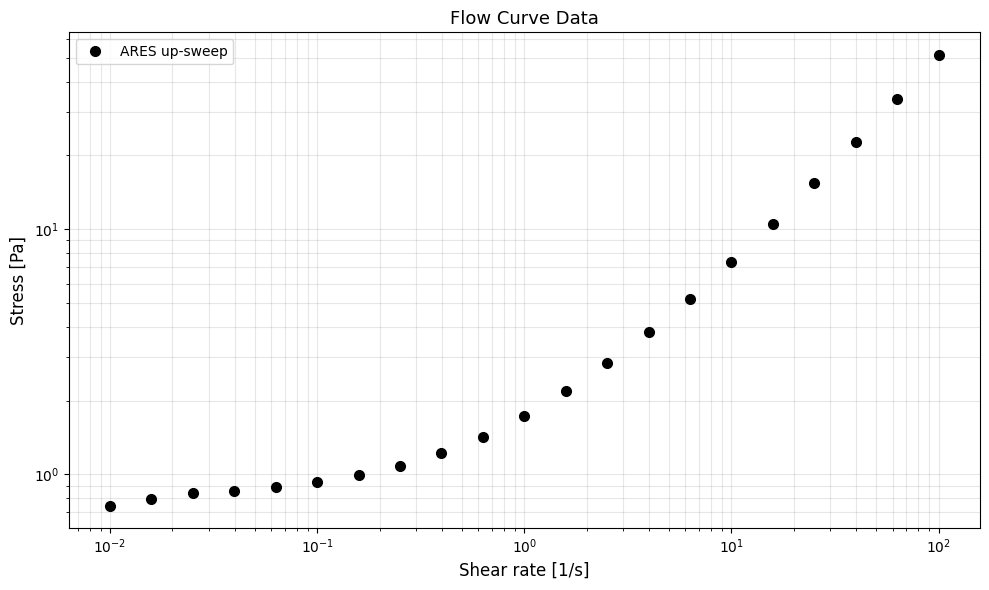

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="ARES up-sweep")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Flow Curve Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Model Setup and Structure Factor

In [5]:
# Create ISM model in glass state
model = ITTMCTIsotropic(phi=0.55)  # Above MCT transition (0.516)

print("Initial model state:")
print(model)
print()
print_glass_state_summary(model)

Initial model state:
ITTMCTIsotropic(φ=0.550 [glass], n_k=100, sk_source='percus_yevick')


Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress


In [6]:
# Examine structure factor
sk_info = model.get_sk_info()
print("Structure Factor Information")
print("=" * 50)
for key, val in sk_info.items():
    print(f"  {key}: {val}")

Structure Factor Information
  source: percus_yevick
  n_k: 100
  k_range: (np.float64(100000.00000000001), np.float64(50000000.0))
  S_max: 4.3492082865619235
  S_max_position: 7156565.656565657
  S_0: 0.009304942973242516


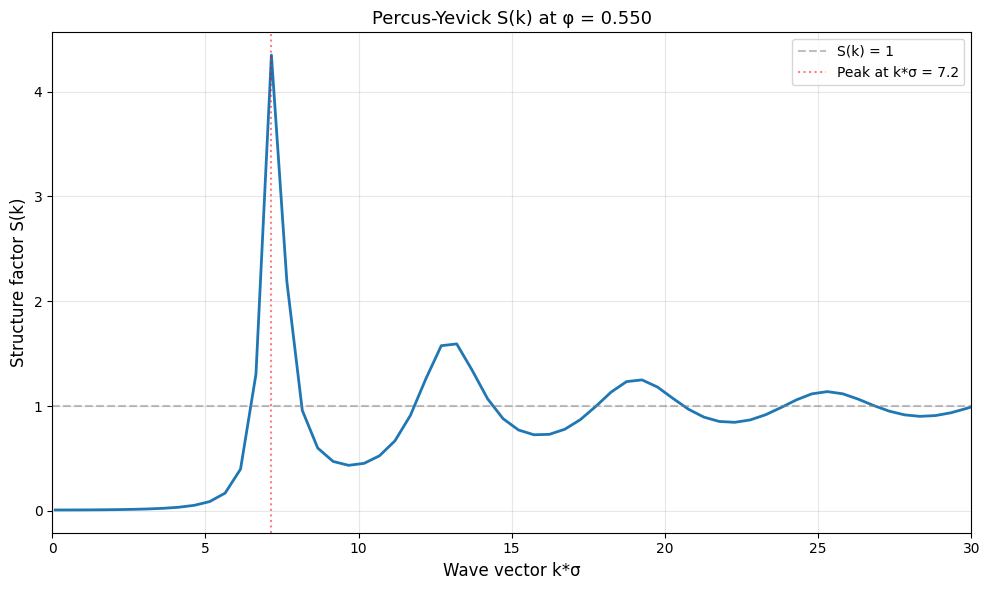

In [7]:
# Plot S(k)
fig, ax = plt.subplots(figsize=(10, 6))

# Get k-grid and S(k) from model
k_grid = model.k_grid
S_k = model.S_k

# Plot
sigma_d = model.parameters.get_value("sigma_d")
k_dimensionless = k_grid * sigma_d  # k*σ

ax.plot(k_dimensionless, S_k, lw=2, color="C0")
ax.axhline(1.0, color="gray", linestyle="--", alpha=0.5, label="S(k) = 1")

# Mark peak
k_peak = k_dimensionless[np.argmax(S_k)]
S_peak = S_k.max()
ax.axvline(k_peak, color="red", linestyle=":", alpha=0.5, 
           label=f"Peak at k*σ = {k_peak:.1f}")

ax.set_xlabel("Wave vector k*σ", fontsize=12)
ax.set_ylabel("Structure factor S(k)", fontsize=12)
ax.set_title(f"Percus-Yevick S(k) at φ = {model.parameters.get_value('phi'):.3f}", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 30)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [8]:
# Fit to flow curve
# We fit: phi, D0, gamma_c (sigma_d and kBT typically fixed)
param_names = ["phi", "D0", "gamma_c"]

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in get_isotropic_param_names():
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 1.48 s

Fitted parameters:
  phi        = 0.55
  sigma_d    = 1.343e-06
  D0         = 9.997e-11
  kBT        = 2.499e-19
  gamma_c    = 0.09997


In [9]:
# Compute fit quality
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   -199645266772432899395942628026103055980290229132713059501958446428339568640.000000
  RMSE: 1.814e+38 Pa
  NRMSE: 357664641151564859356535942629612847104.0000%


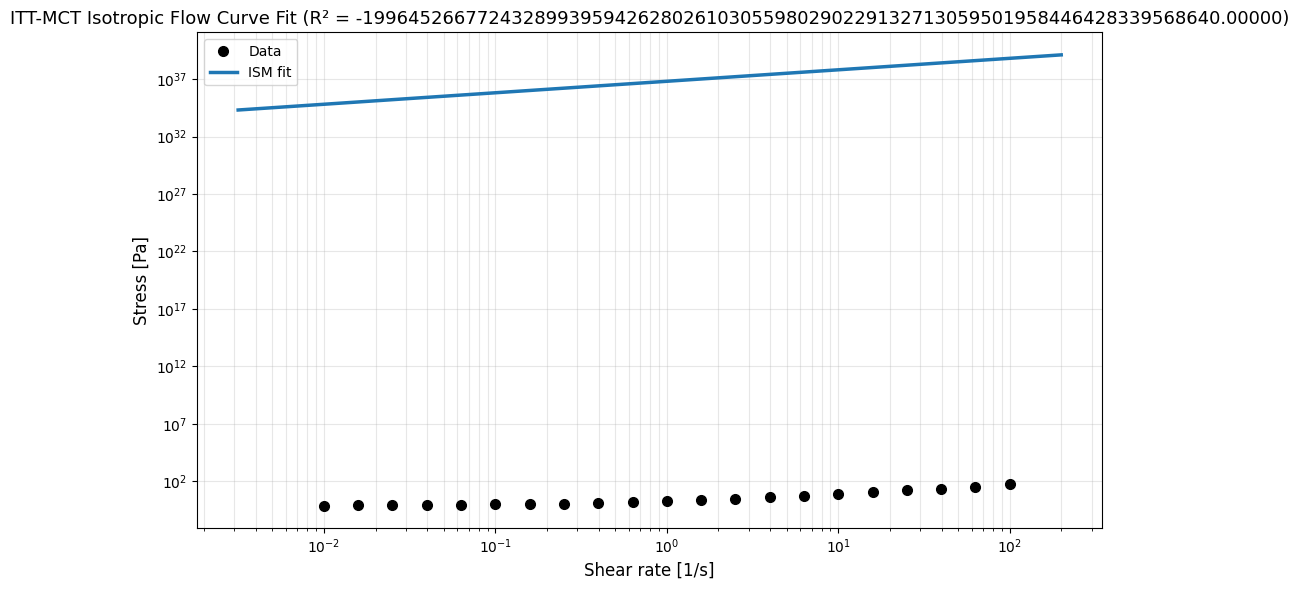

In [10]:
# Plot fit
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    100,
)
stress_pred_fine = model.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.loglog(gamma_dot_fine, stress_pred_fine, "-", lw=2.5, color="C0", 
          label="ISM fit")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"ITT-MCT Isotropic Flow Curve Fit (R² = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.1 Physical Analysis

In [11]:
# Analyze glass state after fitting
print("Fitted Model State")
print("=" * 50)
print_glass_state_summary(model)

# Extract key physics
phi = model.parameters.get_value("phi")
D0 = model.parameters.get_value("D0")
sigma_d = model.parameters.get_value("sigma_d")
kBT = model.parameters.get_value("kBT")
gamma_c = model.parameters.get_value("gamma_c")

print(f"\nKey Physical Properties:")
print(f"  Volume fraction: φ = {phi:.4f}")
print(f"  MCT transition: φ_MCT = 0.516")
print(f"  Distance from transition: Δφ = {phi - 0.516:.4f}")
print(f"  Bare diffusion: D₀ = {D0:.4g} m²/s")
print(f"  Diffusive time scale: τ_D = σ²/D₀ = {sigma_d**2/D0:.4g} s")

Fitted Model State

Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress

Key Physical Properties:
  Volume fraction: φ = 0.5500
  MCT transition: φ_MCT = 0.516
  Distance from transition: Δφ = 0.0340
  Bare diffusion: D₀ = 9.997e-11 m²/s
  Diffusive time scale: τ_D = σ²/D₀ = 0.01804 s


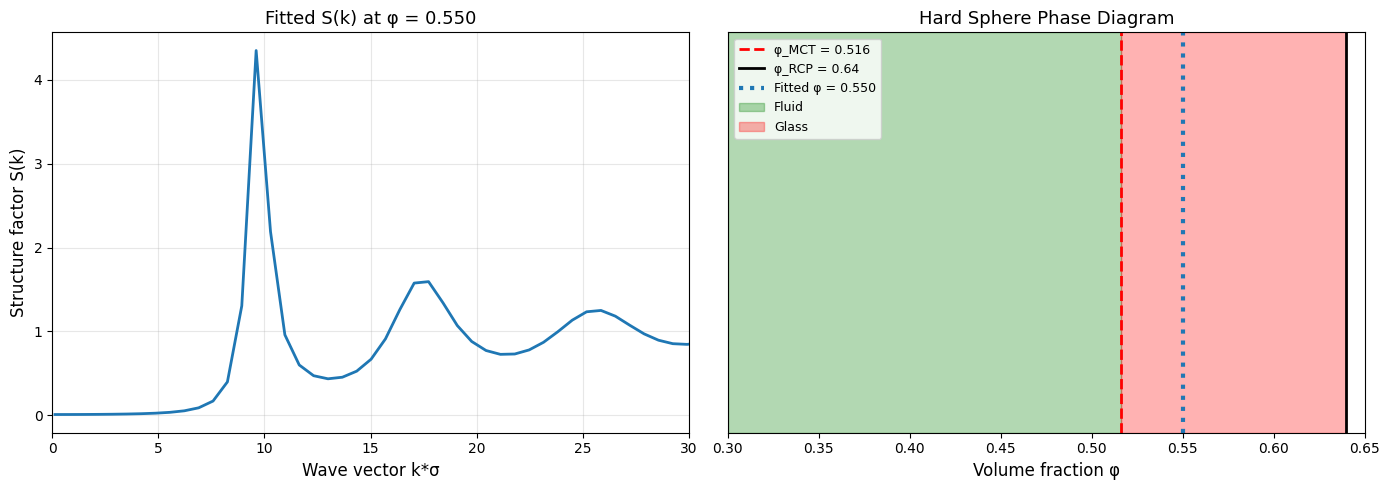

In [12]:
# Compare S(k) before and after fitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Updated S(k)
k_grid = model.k_grid
S_k = model.S_k
k_dimensionless = k_grid * model.parameters.get_value("sigma_d")

ax1.plot(k_dimensionless, S_k, lw=2, color="C0")
ax1.set_xlabel("Wave vector k*σ", fontsize=12)
ax1.set_ylabel("Structure factor S(k)", fontsize=12)
ax1.set_title(f"Fitted S(k) at φ = {phi:.3f}", fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 30)

# Right: Glass transition phase diagram
phi_range = np.linspace(0.3, 0.64, 100)
phi_mct = 0.516
phi_rcp = 0.64

ax2.axvline(phi_mct, color="red", linestyle="--", lw=2, label="φ_MCT = 0.516")
ax2.axvline(phi_rcp, color="black", linestyle="-", lw=2, label="φ_RCP = 0.64")
ax2.axvline(phi, color="C0", linestyle=":", lw=3, label=f"Fitted φ = {phi:.3f}")

ax2.fill_between([0.3, phi_mct], 0, 1, alpha=0.3, color="green", label="Fluid")
ax2.fill_between([phi_mct, phi_rcp], 0, 1, alpha=0.3, color="red", label="Glass")

ax2.set_xlabel("Volume fraction φ", fontsize=12)
ax2.set_ylabel("", fontsize=12)
ax2.set_title("Hard Sphere Phase Diagram", fontsize=13)
ax2.legend(fontsize=9, loc="upper left")
ax2.set_xlim(0.3, 0.65)
ax2.set_ylim(0, 1)
ax2.set_yticks([])

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference with NUTS

In [13]:
try:
    # Prepare warm-start from NLSQ
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    print("Warm-start values:")
    for name, val in initial_values.items():
        print(f"  {name:10s} = {val:.4g}")
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    # NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production
    
    print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        gamma_dot,
        stress,
        test_mode="flow_curve",
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:Missing 'model_function' method for Bayesian inference


ERROR:rheojax.core.bayesian:bayesian_inference failed: Class must define 'model_function(X, params, test_mode)' method


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 457, in fit_bayesian
    result = super().fit_bayesian(
        X,
    ...<7 lines>...
        **nuts_kwargs,
    )
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 919, in fit_bayesian
    self._validate_bayesian_requirements()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 285, in _validate_bayesian_requirements
    raise AttributeError(
        "Class must define 'model_function(X, params, test_mode)' method"
    )
AttributeError: Class must define 'model_function(X, params, test_mode)' method


Warm-start values:
  phi        = 0.55
  D0         = 9.997e-11
  gamma_c    = 0.09997

Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: Class must define 'model_function(X, params, test_mode)' method
NLSQ results are reported above.


In [14]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (ISM)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [16]:
if result is not None:
    # Forest plot
    axes = az.plot_forest(idata, var_names=param_names, combined=True, 
                           hdi_prob=0.95, figsize=(10, 5))
    fig = axes.ravel()[0].figure
    fig.suptitle("95% Credible Intervals", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


### 6.3 Posterior Predictive Check

In [17]:
if result is not None:
    # Posterior predictive
    posterior = result.posterior_samples
    n_draws = min(50, len(list(posterior.values())[0]))  # Fewer for ISM (slower)
    
    pred_samples = []
    for i in range(n_draws):
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        # Update S(k) for new phi
        model.update_structure_factor()
        pred_i = model.predict(gamma_dot_fine, test_mode="flow_curve")
        pred_samples.append(np.array(pred_i))
    
    pred_samples = np.array(pred_samples)
    pred_median = np.median(pred_samples, axis=0)
    pred_lo = np.percentile(pred_samples, 2.5, axis=0)
    pred_hi = np.percentile(pred_samples, 97.5, axis=0)
    
    # Restore parameters
    for name, val in initial_values.items():
        model.parameters.set_value(name, val)
    model.update_structure_factor()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(gamma_dot_fine, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
    ax.loglog(gamma_dot_fine, pred_median, "-", lw=2, color="C0", label="Posterior median")
    ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
    ax.set_xlabel("Shear rate [1/s]", fontsize=12)
    ax.set_ylabel("Stress [Pa]", fontsize=12)
    ax.set_title("Posterior Predictive Check (ISM)", fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which="both")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [18]:
if result is not None:
    # Parameter comparison
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Physical Interpretation

### ISM vs Schematic Comparison

The Isotropic model provides:
- **Quantitative predictions** for hard spheres
- **Structure factor dependence** on concentration
- **k-resolved dynamics** for detailed analysis

The control parameter is now **volume fraction φ** rather than the abstract vertex v₂.

### Glass Transition

- φ < 0.516: Particles can diffuse, viscous flow
- φ > 0.516: Particles caged, yield stress emerges
- φ → 0.64: Random close packing, stress diverges

In [19]:
# Summary
print("ISM Flow Curve Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nKey Results:")
print(f"  Fitted volume fraction: φ = {model.parameters.get_value('phi'):.4f}")
print(f"  Distance from MCT: Δφ = {model.parameters.get_value('phi') - 0.516:.4f}")
print(f"  S(k) peak height: S_max = {model.S_k.max():.2f}")

ISM Flow Curve Summary

Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress

Key Results:
  Fitted volume fraction: φ = 0.5500
  Distance from MCT: Δφ = 0.0340
  S(k) peak height: S_max = 4.35


## 8. Save Results

Save parameters for use in synthetic data generation:
- **NB09:** Stress Relaxation
- **NB10:** Creep
- **NB11:** SAOS

In [20]:
# Save results
save_itt_mct_results(model, result, "isotropic", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB09: Stress Relaxation")
print("  - NB10: Creep")
print("  - NB11: SAOS")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/isotropic/flow_curve/
  nlsq_params_flow_curve.json: 3 parameters

Parameters saved for synthetic data generation in:
  - NB09: Stress Relaxation
  - NB10: Creep
  - NB11: SAOS


## Key Takeaways

1. **ISM** uses volume fraction φ as the control parameter (glass at φ > 0.516)

2. **Percus-Yevick S(k)** provides structure factor for hard spheres

3. **k-resolved correlators** enable quantitative stress predictions

4. **MCT glass transition** at φ_MCT ≈ 0.516 for hard spheres

5. **Parameters calibrated here** will generate synthetic data for:
   - Relaxation (NB09)
   - Creep (NB10)
   - SAOS (NB11)

### Next Steps

- **NB08:** ISM Startup Shear
- **NB09:** ISM Stress Relaxation (synthetic)
- **NB10:** ISM Creep (synthetic)
- **NB11:** ISM SAOS (synthetic)
- **NB12:** ISM LAOS